# CMA-MAE and Archive Thresholds

In this tutorial, we demonstrate how to implement the Covariance Matrix Adaptation MAP-Annealing (CMA-MAE) algorithm introduced in [Fontaine 2022](https://arxiv.org/abs/2205.10752).

_This tutorial assumes that you are familiar with Covariance Matrix Adaptation MAP-Elites (CMA-ME). If you are not familiar with CMA-ME, we recommend reviewing the following tutorials:_
- [Using CMA-ME to Land a Lunar Lander Like a Space Shuttle](https://docs.pyribs.org/en/stable/tutorials/lunar_lander.html)
- [Illuminating the Latent Space of an MNIST GAN](https://docs.pyribs.org/en/stable/tutorials/lsi_mnist.html)

## Setup

First, we install pyribs and import utilities.

In [ ]:
%pip install ribs[visualize]

In [1]:
import matplotlib.pyplot as plt
import numpy as np

Next, let's define the sphere function and its gradients.

This method is adapted from Section 4 of [Fontaine 2020](https://arxiv.org/abs/1912.02400) and differs from the standard [sphere function](https://en.wikipedia.org/wiki/Sphere) in several ways. First, each solution value is clipped to the range $[-5.12, 5.12]$, and the optimum is moved from $[0,..]$ to $[0.4 \times 5.12 = 2.048,..]$. Second, the objectives are normalized to the range $[0,100]$ where $100$ is the maximum and corresponds to $0$ on the original sphere function.

There are two measures in this example. The first is the sum of the first $\frac{n}{2}$ clipped values of the solution, and the second is the sum of the last $\frac{n}{2}$ clipped values of the solution. Having each measure depend equally on several values in the solution space makes the problem more difficult (refer to [Fontaine 2020](https://arxiv.org/abs/1912.02400) for more details).

In [2]:
def sphere(solution_batch):
    """Sphere function evaluation and measures for a batch of solutions.

    Args:
      solution_batch (np.ndarray): (batch_size, dim) batch of solutions.
    Returns:
      objective_batch (np.ndarray): (batch_size,) batch of objectives.
      measures_batch (np.ndarray): (batch_size, 2) batch of measures.
    """
    dim = solution_batch.shape[1]

    # Shift the Sphere function so that the optimal value is at x_i = 2.048.
    sphere_shift = 5.12 * 0.4

    # Normalize the objective to the range [0, 100] where 100 is optimal.
    best_obj = 0.0
    worst_obj = (-5.12 - sphere_shift)**2 * dim
    raw_obj = np.sum(np.square(solution_batch - sphere_shift), axis=1)
    objective_batch = (raw_obj - worst_obj) / (best_obj - worst_obj) * 100

    # Compute gradient of the objective
    objective_grad_batch = -2 * (solution_batch - sphere_shift)

    # Calculate measures.
    clipped = solution_batch.copy()
    clip_indices = np.where(np.logical_or(clipped > 5.12, clipped < -5.12))
    clipped[clip_indices] = 5.12 / clipped[clip_indices]
    measures_batch = np.concatenate(
      (
          np.sum(clipped[:, :dim // 2], axis=1, keepdims=True),
          np.sum(clipped[:, dim // 2:], axis=1, keepdims=True),
      ),
      axis=1,
    )

    # Compute gradient of the measures
    derivatives = np.ones(solution_batch.shape)
    derivatives[clip_indices] = -5.12 / np.square(solution_batch[clip_indices])

    mask_0 = np.concatenate((np.ones(dim // 2), np.zeros(dim - dim // 2)))
    mask_1 = np.concatenate((np.zeros(dim // 2), np.ones(dim - dim // 2)))

    d_measure0 = derivatives * mask_0
    d_measure1 = derivatives * mask_1

    measures_grad_batch = np.stack((d_measure0, d_measure1), axis=1)

    return (
      objective_batch,
      objective_grad_batch,
      measures_batch,
      measures_grad_batch,
    )

## Overview of CMA-MAE

After CMA-ME finds a high-objective solution, all subsequent solutions found in the same region will be neglected since they have much lower objective value. Consequently, CMA-ME will rapidly move away from a high-performing solution after discovering it.

The intuition of CMA-MAE is that there could be value in discovering more solutions in a high-objective region. For instance, there could be even better solutions in the same region, but CMA-ME will move away from the region regardless if it does not discover a better solution in the next few iterations.

CMA-MAE overcomes this problem by using a threshold value (not the objective value) to determine whether a new solution is accepted by the archive. Formally, a new solution $\theta'$ in cell $e$ is accepted to the archive if and only if $f(\theta') > t_e$, where $t_e$ is the threshold of cell $e$, and $f(\theta')$ computes the objective value of $\theta'$. The improvement value of a solution is calculated as $$\Delta = f(\theta') - t_e$$

Furthermore, after $\theta'$ is accepted into cell $e$, $t_e$ is updated according to the following equation $$t_e \gets (1 - \alpha) t_e + \alpha f(\theta')$$ where the constant $\alpha$ denotes the _archive learning rate_ and controls how quickly the threshold is adapted.

When $\alpha = 1$, **CMA-MAE behaves like CMA-ME**, with the improvement values $\Delta$ quickly dropping to zero (an observation that [Fontaine 2022](https://arxiv.org/abs/2205.10752) discusses more formally).

When a cell does not yet have a solution, its threshold is initialized to a predefined minimum threshold $min_f$.

Using an example from the paper:
> Consider discovering solutions in the same cell with objective value 100 in 5 consecutive iterations. The improvement values computed by CMA-ME would be 100, 0, 0, 0, 0, thus CMA-ME would move rapidly away from this cell. The improvement values computed by CMA-MAE with α = 0.5 would diminish smoothly as follows: 100, 50, 25, 12.5, 6.25, enabling further exploitation of the high-performing region.

## CMA-MAE with pyribs

We will create a `GridArchive` with the following parameters from Fontaine 2022. In particular, we use a learning rate $\alpha = 0.01$ and minimum threshold $min_f = 0$.

**Note: If your solutions $\theta'$ consistently have objective values $f(\theta') = min_f$, you may need to set $min_f$ to be slightly smaller so that these solutions are accepted into the archive. This is because solutions are accepted if and only if $f(\theta') > t_e$. Thus, if $f(\theta') = t_e$, then $\theta'$ will not be accepted.**

In [3]:
from ribs.archives import GridArchive

solution_dim = 100
archive_dims = (100, 100)
max_bound = solution_dim / 2 * 5.12
bounds = [(-max_bound, max_bound), (-max_bound, max_bound)]
learning_rate = 0.01

archive = GridArchive(solution_dim=solution_dim,
                      dims=archive_dims,
                      ranges=bounds,
                      learning_rate=learning_rate,
                      threshold_min=0)

Since solutions are added to the archive based on the cell's **threshold** rather than the cell's **objective**, it is possible for CMA-MAE to make backwards progress. Specifically, a solution's objective can exceed the cell's threshold value but not exceed the objective of the cell's current occupant, which results in overwriting the **better** solution.

For this reason, CMA-MAE requires a separate **result archive** that keeps track of the best solutions encountered in each cell. Fortunately, this is exactly the default behavior of `GridArchive`, with `learning_rate = 0` and `threashold_min=-inf`.

In [43]:
result_archive = GridArchive(solution_dim=solution_dim,
                             dims=archive_dims,
                             ranges=bounds)

CMA-MAE is based on CMA-ME. The original conception of CMA-MAE uses 15 instances of `EvolutionStrategyEmitter` as defined in the following cell.

> We encourage you to play around with the parameters of this emitter (i.e. `x0`, `sigma0`, `ranker`, `selection_rule`, `restart_rule`, and `batch_size`), or experiment with different combination of emitters (such as mixing different emitters together). The setup that we are using might not be optimal!

In [44]:
from ribs.emitters import EvolutionStrategyEmitter

emitters = [
    EvolutionStrategyEmitter(
        archive,
        x0=np.zeros(solution_dim),
        sigma0=0.5,
        ranker="imp",
        selection_rule="mu",
        restart_rule="basic",
        batch_size=36,
    ) for _ in range(15)
]

Finally, we can create a `Scheduler` with an additional parameter `result_archive`. The `Scheduler` class will be responsible for interacting with the `result_archive` so that it keeps track of the best solutions.

In [45]:
from ribs.schedulers import Scheduler

scheduler = Scheduler(archive, emitters, result_archive=result_archive)

## Aside: Setting learning_rate and threshold_min

The pyribs archives (except for `SlidingBoundariesArchive`) feature a `learning_rate` and `threshold_min` parameter which lead to different behaviors. In particular, the original CMA-ME computed improvement with two stages: (1) the solution's status (i.e., whether it was new, improved an existing cell in the archive, or was not inserted at all), and (2) a value which depended on the status.

In contrast, CMA-MAE computes a single improvement value $\Delta$ which is computed in the same manner regardless of the solution's status. However, this may lead to slightly different behavior than CMA-ME in some cases, and CMA-MAE also requires $min_f$ to always be passed in, while CMA-ME does not.

Thus, we have made it possible to activate the original CMA-ME behavior by passing in $\alpha=1$ and $min_f=-\infty$. The table below shows all the possible values of `learning_rate` and `threshold_min` for the archives.

| `learning_rate` ($\alpha$) | `threshold_min` ($min_f$) | Improvement values          |
| -------------------------- | ------------------------- | --------------------------- |
| $1$                        | $-\infty$                 | Two-stage (CMA-ME)          |
| $0\le\alpha\le1$           | (any value)               | $f(\theta) - t_e$ (CMA-MAE) |

Supporting this behavior introduces several additional considerations:
* When performing batch addition via the `add()` method on an archive with the CMA-ME settings, we update the threshold by taking the maximum objective value, as opposed to applying the CMA-MAE batch addition rule in Appendix H of Fontaine 2022 (however, the batch addition rule is applied when using CMA-MAE settings).
* When using the CMA-ME settings, using any ranker which is not `TwoStage` is not advisable, as CMA-ME is only designed to work with two-stage ranking.

## Running the CMA-MAE (5 minutes on Google Colab)

Now we run CMA-MAE for 10000 iterations in accordance with the experiments in [Fontaine 2022](https://arxiv.org/abs/2205.10752). Note that we report the **normalized QD score** here, which is the QD score divided by the number of cells in the archive.

In [46]:
total_itrs = 10_000

for itr in range(1, total_itrs + 1):
    solution_batch = scheduler.ask()
    objective_batch, _, measure_batch, _ = sphere(solution_batch)
    scheduler.tell(objective_batch, measure_batch)

    # Output progress every 500 iteration or on the final iteration.
    if itr % 500 == 0 or itr == total_itrs:
        print(f"Iteration {itr} | Archive Coverage:"
              f"{result_archive.stats.coverage * 100:.3f}% "
              f"Normalized QD Score: {result_archive.stats.norm_qd_score:.3f}")

Iteration 500 | Archive Coverage:34.400% Normalized QD Score: 24.639
Iteration 1000 | Archive Coverage:50.070% Normalized QD Score: 36.271
Iteration 1500 | Archive Coverage:60.830% Normalized QD Score: 45.024
Iteration 2000 | Archive Coverage:71.680% Normalized QD Score: 54.999
Iteration 2500 | Archive Coverage:75.490% Normalized QD Score: 58.716
Iteration 3000 | Archive Coverage:78.060% Normalized QD Score: 60.996
Iteration 3500 | Archive Coverage:78.220% Normalized QD Score: 61.218
Iteration 4000 | Archive Coverage:78.550% Normalized QD Score: 61.497
Iteration 4500 | Archive Coverage:78.720% Normalized QD Score: 61.684
Iteration 5000 | Archive Coverage:78.920% Normalized QD Score: 61.852
Iteration 5500 | Archive Coverage:79.330% Normalized QD Score: 62.101
Iteration 6000 | Archive Coverage:79.540% Normalized QD Score: 62.259
Iteration 6500 | Archive Coverage:79.540% Normalized QD Score: 62.288
Iteration 7000 | Archive Coverage:79.540% Normalized QD Score: 62.313
Iteration 7500 | Arch

## Visualization

Now we visualize the result archive with `grid_archive_heatmap` (as previously noted, the archive used in the main algorithm does not always hold the best solutions, while the result archive does).

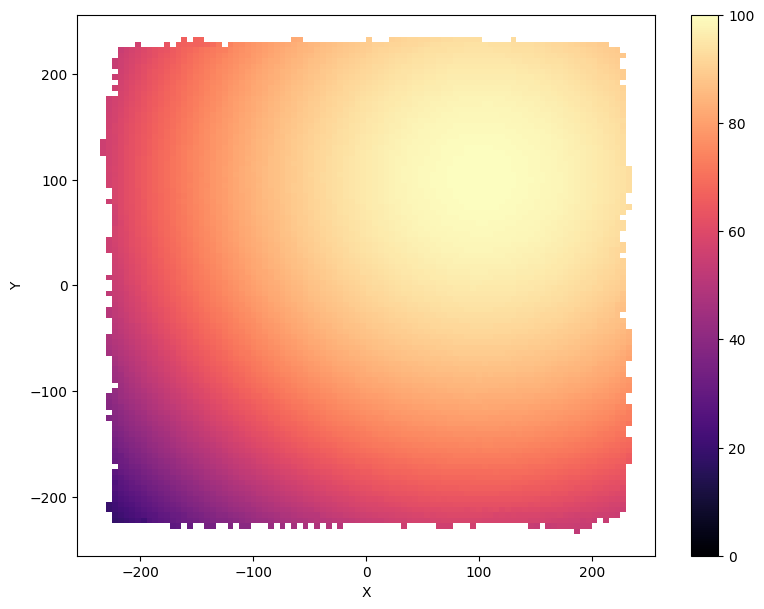

In [47]:
from ribs.visualize import grid_archive_heatmap

plt.figure(figsize=(8, 6))
grid_archive_heatmap(result_archive, vmin=0, vmax=100)
plt.tight_layout()
plt.ylabel("Y")
plt.xlabel("X")
plt.show()

## Exploring the Effect of Learning Rate $\alpha$

In the previous section, we explored CMA-MAE using $\alpha = 0.01$, but what about other settings of $\alpha$? Here we explore how different learning rates affect CMA-MAE on the sphere function. We first define a method for creating a scheduler with a given `learning_rate`.

In [10]:
def create_scheduler(learning_rate):
    solution_dim = 100
    archive_dims = (100, 100)
    max_bound = solution_dim / 2 * 5.12
    bounds = [(-max_bound, max_bound), (-max_bound, max_bound)]

    archive = GridArchive(solution_dim=solution_dim,
                          dims=archive_dims,
                          ranges=bounds,
                          learning_rate=learning_rate,
                          threshold_min=0)

    result_archive = GridArchive(solution_dim=solution_dim,
                                 dims=archive_dims,
                                 ranges=bounds)

    emitters = [
      EvolutionStrategyEmitter(
          archive,
          x0=np.zeros(solution_dim),
          sigma0=0.5,
          ranker="imp",
          selection_rule="mu",
          restart_rule="basic",
          batch_size=36,
      ) for _ in range(15)
    ]

    return Scheduler(archive, emitters, result_archive=result_archive)

Then, we run the experiments with various learning rates while keeping track of the performance (normalized QD score and archive coverage) for each learning rate. **This took 15 minutes on Google Colab.**

> Note that the iterations are adjusted from `10000` to `5000` to save time.

In [13]:
from ribs.archives import GridArchive
from ribs.emitters import EvolutionStrategyEmitter
from ribs.schedulers import Scheduler

# The learning rates that we run CMA-MAE with.
learning_rates = [0, 0.001, 0.01, 0.1, 1]

# Run for 5000 iterations.
total_itrs = 5000

# Tracks the metrics of all the experiments.
all_metrics = {}

for learning_rate in learning_rates:
    # Create scheduler
    scheduler = create_scheduler(learning_rate)
    result_archive = scheduler.result_archive

    metrics = {
    "Normalized QD Score": {
        "x": [0],
        "y": [0.0],
    },
    "Archive Coverage": {
        "x": [0],
        "y": [0.0],
    },
    }

    print(f"Running CMA-MAE with learning_rate = {learning_rate}")
    for itr in range(1, total_itrs + 1):
        solution_batch = scheduler.ask()
        objective_batch, _, measure_batch, _ = sphere(solution_batch)
        scheduler.tell(objective_batch, measure_batch)

        # Output and record metrics every 250 iteration or on the final iteration.
        if itr % 250 == 0 or itr == total_itrs:
            print(f"Iteration {itr} | Archive Coverage:"
                  f"{result_archive.stats.coverage * 100:.3f}% "
                  f"Normalized QD Score: {result_archive.stats.norm_qd_score:.3f}")

            metrics["Normalized QD Score"]["x"].append(itr)
            metrics["Normalized QD Score"]["y"].append(result_archive.stats.norm_qd_score)
            metrics["Archive Coverage"]["x"].append(itr)
            metrics["Archive Coverage"]["y"].append(result_archive.stats.coverage * 100)

        all_metrics[learning_rate] = metrics


Running CMA-MAE with learning_rate = 0
Iteration 250 | Archive Coverage:3.100% Normalized QD Score: 2.995
Iteration 500 | Archive Coverage:3.100% Normalized QD Score: 2.995
Iteration 750 | Archive Coverage:3.240% Normalized QD Score: 3.138
Iteration 1000 | Archive Coverage:3.240% Normalized QD Score: 3.138
Iteration 1250 | Archive Coverage:3.400% Normalized QD Score: 3.295
Iteration 1500 | Archive Coverage:3.400% Normalized QD Score: 3.295
Iteration 1750 | Archive Coverage:3.400% Normalized QD Score: 3.295
Iteration 2000 | Archive Coverage:3.620% Normalized QD Score: 3.506
Iteration 2250 | Archive Coverage:3.620% Normalized QD Score: 3.506
Iteration 2500 | Archive Coverage:3.940% Normalized QD Score: 3.813
Iteration 2750 | Archive Coverage:3.940% Normalized QD Score: 3.813
Iteration 3000 | Archive Coverage:4.020% Normalized QD Score: 3.891
Iteration 3250 | Archive Coverage:4.180% Normalized QD Score: 4.043
Iteration 3500 | Archive Coverage:4.180% Normalized QD Score: 4.043
Iteration 37

Now, we can plot the metrics for each learning rate.

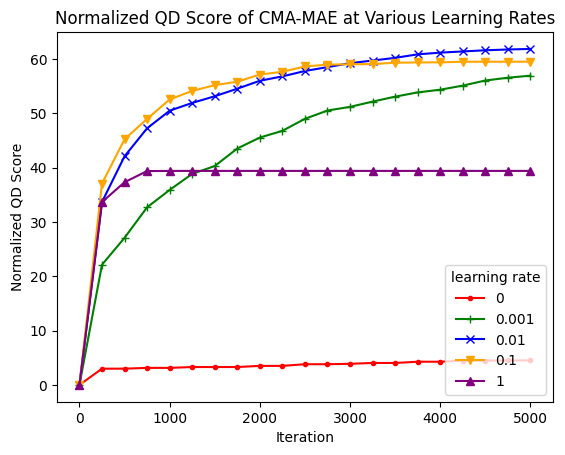

In [35]:
# Add markers for accessiblity.
plt.gca().set_prop_cycle(color=['red', 'green', 'blue', 'orange', 'purple'],
                         marker=['.', '+', 'x', 'v', '^'])

for learning_rate in learning_rates:
    metrics = all_metrics[learning_rate]
    plt.plot(metrics["Normalized QD Score"]["x"], metrics["Normalized QD Score"]["y"])
    plt.title("Normalized QD Score of CMA-MAE at Various Learning Rates")
    plt.xlabel("Iteration")
    plt.ylabel("Normalized QD Score")
plt.legend(learning_rates, title="learning rate")
plt.show()

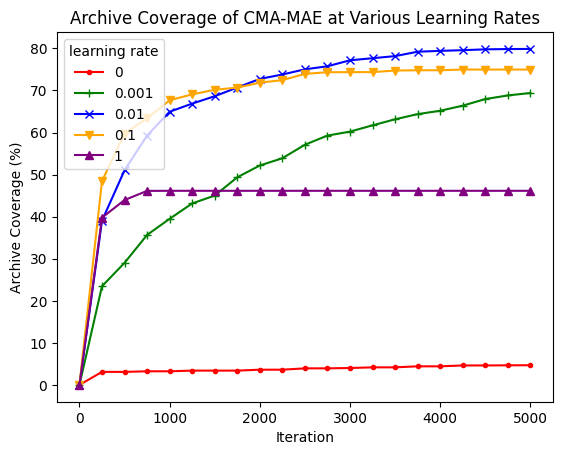

In [36]:
# Add markers for accessiblity.
plt.gca().set_prop_cycle(color=['red', 'green', 'blue', 'orange', 'purple'],
                         marker=['.', '+', 'x', 'v', '^'])

for learning_rate in learning_rates:
    metrics = all_metrics[learning_rate]
    plt.plot(metrics["Archive Coverage"]["x"], metrics["Archive Coverage"]["y"])
    plt.title("Archive Coverage of CMA-MAE at Various Learning Rates")
    plt.xlabel("Iteration")
    plt.ylabel("Archive Coverage (%)")
plt.legend(learning_rates, title="learning rate")
plt.show()

From the plots, we observe the following:

- With learning rate 0, the algorithm makes no progress in exploring the archive, resulting in the lowest QD score.
- With learning rate 1, the algorithm stops making progress after around 500 iterations (recall that this is the behavior of CMA-ME).
- With learning rate 0.001, the algorithm falls behind CMA-ME but consistently makes progress in exploring the archive, eventually surpassing CMA-ME at around 1500 iterations.
- With learning rate 0.01 and 0.1, the algorithm makes quick progress, surpassing the performance of all other learning rate settings.

Finally, from this experiment we observe that learning rate 0.01 is more optimal for the sphere function as the number of iteration increases.

## Extension: CMA-MAEGA with pyribs

CMA-MAEGA, proposed in the same paper as CMA-MAE, is a variant of CMA-MAE that combines archive thresholds with Covariance Matrix Adaptation MAP-Elites via a Gradient Arborescence (CMA-MEGA).

> For more details on CMA-MEGA, refer to [Fontaine 2021](https://arxiv.org/abs/2106.03894).

We can easily implement this algorithm by replacing `EvolutionStrategyEmitter` with `GradientArborescenceEmitter` in CMA-MAE.

In [49]:
from ribs.archives import GridArchive
from ribs.emitters import GradientArborescenceEmitter
from ribs.schedulers import Scheduler

solution_dim = 100
archive_dims = (100, 100)
max_bound = solution_dim / 2 * 5.12
bounds = [(-max_bound, max_bound), (-max_bound, max_bound)]
learning_rate = 0.01

archive = GridArchive(solution_dim=solution_dim,
                      dims=archive_dims,
                      ranges=bounds,
                      learning_rate=learning_rate,
                      threshold_min=0)

result_archive = GridArchive(solution_dim=solution_dim,
                             dims=archive_dims,
                             ranges=bounds)

# Use GradientArborescenceEmitter instead of EvolutionStrategyEmitter.
emitters = [
    GradientArborescenceEmitter(
        archive,
        x0=np.zeros(solution_dim),
        sigma0=10.0,
        step_size=1.0,
        ranker="imp",
        grad_opt="gradient_ascent",
        restart_rule="basic",
        bounds=None,
        batch_size=36,
    ) for _ in range(15)
]

scheduler = Scheduler(archive, emitters, result_archive=result_archive)

We can run the algorithm in a similar fashion as CMA-MAE. Note that since `GradientArborescenceEmitter` uses gradient information of the objective function, we need to evaluate the gradient of the solutions returned by `ask_dqd` and pass the results to `tell_dqd`.

TODO: Link to the DQD tutorial here.

In [50]:
total_itrs = 4500

for itr in range(1, total_itrs + 1):
    # DQD ask-tell.
    solution_batch = scheduler.ask_dqd()

    (objective_batch, objective_grad_batch, measures_batch, measures_grad_batch) = sphere(solution_batch)

    objective_grad_batch = np.expand_dims(objective_grad_batch, axis=1)
    jacobian_batch = np.concatenate((objective_grad_batch, measures_grad_batch), axis=1)
    scheduler.tell_dqd(objective_batch, measures_batch, jacobian_batch)

    # ask-tell.
    solution_batch = scheduler.ask()
    objective_batch, _, measure_batch, _ = sphere(solution_batch)
    scheduler.tell(objective_batch, measure_batch)

    # Logging and output every 500 iteration or on final iteration.
    if itr % 500 == 0 or itr == total_itrs:
        print(f"Iteration {itr} | Archive Coverage:"
              f"{result_archive.stats.coverage * 100:.3f}% "
              f"Normalized QD Score: {result_archive.stats.norm_qd_score:.3f}")

Iteration 500 | Archive Coverage:95.150% Normalized QD Score: 65.534
Iteration 1000 | Archive Coverage:99.000% Normalized QD Score: 74.983
Iteration 1500 | Archive Coverage:99.750% Normalized QD Score: 75.233
Iteration 2000 | Archive Coverage:99.970% Normalized QD Score: 75.309
Iteration 2500 | Archive Coverage:100.000% Normalized QD Score: 75.335
Iteration 3000 | Archive Coverage:100.000% Normalized QD Score: 75.346
Iteration 3500 | Archive Coverage:100.000% Normalized QD Score: 75.353
Iteration 4000 | Archive Coverage:100.000% Normalized QD Score: 75.359
Iteration 4500 | Archive Coverage:100.000% Normalized QD Score: 75.363


Notice that the CMA-MEGA fully explores the archive around 2000 iterations, much better than CMA-MAE. It also outperforms CMA-MAE. Now, let's visualize the result archive.

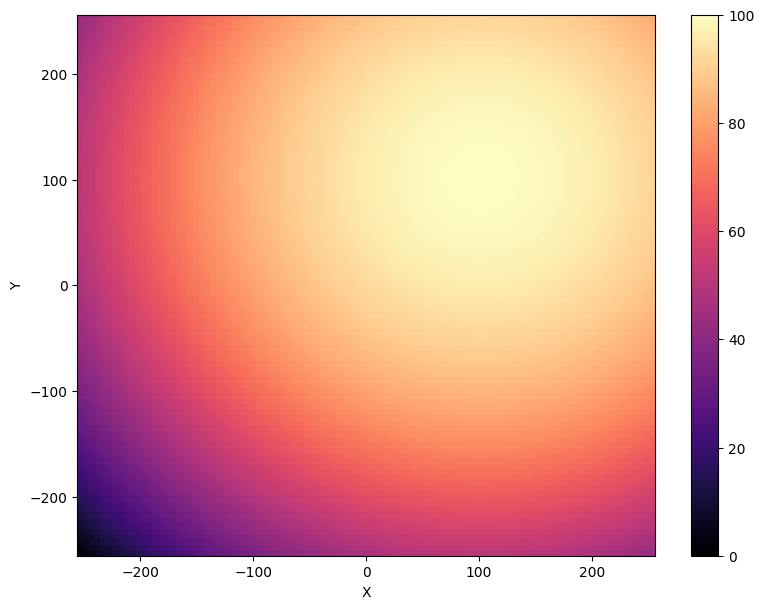

In [51]:
from ribs.visualize import grid_archive_heatmap

plt.figure(figsize=(8, 6))
grid_archive_heatmap(result_archive, vmin=0, vmax=100)
plt.tight_layout()
plt.ylabel("Y")
plt.xlabel("X")
plt.show()

## Conclusion

In this tutorial, we introduced CMA-MAE and showed how it is implemented in pyribs. We also demonstrated CMA-MAE on the sphere function with several different settings of its learning rate parameter $\alpha$. Finally, we showed how these ideas extend to differentiable quality diversity with the CMA-MAEGA algorithm.

## Citation

If you find this tutorial useful, please cite it as:

```text
@article{pyribs_cma_mae,
  title   = {CMA-MAE and Archive Thresholds},
  author  = {David H. Lee and Bryon Tjanaka and Matthew C. Fontaine and Stefanos Nikolaidis},
  journal = {pyribs.org},
  year    = {2022},
  url     = {https://docs.pyribs.org/en/stable/tutorials/cma_mae.html}
}
```